In [1]:
import sys

sys.path.append('/home/anton/Documents/Tulane/Research/demo-vae/pip/src/')

from demovae import DemoVAE

field = '26206-0.0'

vae = DemoVAE(pperiod=50, use_cuda=True, nepochs=10000, latent_dim=120, weight_decay=0, lr=5e-5, loss_rec_mult=1e3,
              loss_pred_mult=0.01, loss_C_mult=1e4)
vae.load(f'/home/anton/Documents/Yale/UKB/VAE_Models/700_subs/{field}.pkl')

print('Done')

/home/anton/Documents/Tulane/Research/demo-vae/pip/src/demovae/sklearn.py:114: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dct = torch.load(path)


Done


In [2]:
import pickle

dct = pickle.load(open(f'/home/anton/Documents/Yale/UKB/VAE_Models/700_subs/demos_{field}.pkl', 'rb'))

print(list(dct.keys()))
print('Done')

['demos', 'types']
Done


In [3]:
# Load ADNI model

import pickle

adni = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/weightsBalanced3.pkl', 'rb'))
# adni = {'coef': None, 'intercept': 0}
# adni['coef'] = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/corrBalanced.pkl', 'rb'))

list(adni.keys())

['intercept', 'coef']

In [4]:
# Load sub FCS

import numpy as np

inter_subs_fc = pickle.load(open('/home/anton/Documents/Yale/UKB/inter_subs_fc.pkl', 'rb'))
fcs = []
count = 0

for sub in inter_subs_fc:
    p = np.load(f'/home/anton/Documents/Tulane/Research/ImageNomer/data/UKB3/conn/{sub}_task-20227-2_fc.npy')
    fcs.append(p)
    count += 1
    if count == 700:
        break

fcs = np.stack(fcs)
print(len(fcs))

700


In [74]:
dct['demos'][4][:20]

array([-1.22605  , -0.359051 ,  0.883655 , -0.325426 , -0.76638  ,
       -0.396856 , -0.173645 , -0.310701 , -1.15302  , -0.756275 ,
        0.278442 , -0.261701 ,  1.29385  , -0.595514 , -0.642173 ,
       -0.100867 ,  0.0580313,  1.2636   , -2.21859  , -0.655769 ])

In [75]:
import numpy as np

vals = []
synth_mean = np.zeros(34716)

for i in range(20):
    synth = vae.transform(len(dct['demos'][0]), dct['demos'], dct['types'])
    # synth = vae.transform(fcs, dct['demos'], dct['types'])
    synth_mean += np.mean(synth, axis=0)/20
    
    b = adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in synth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(synth))

print(np.mean(vals))
print(np.std(vals))

-69.94465867169205
2.2410489484970966


In [76]:
vals = []
nsynth_mean = np.zeros(34716)

for i in range(20):
    ndemo = []
    for d in dct['demos']:
        dd = d+0
        ndemo.append(dd)

    # ndemo[4] = 0*np.ones(len(ndemo[1]))
    ndemo[4] += 3
    
    nsynth = vae.transform(len(dct['demos'][0]), ndemo, dct['types'])
    # nsynth = vae.transform(fcs, ndemo, dct['types'])
    nsynth_mean += np.mean(nsynth, axis=0)/20

    b = adni['intercept']
    w = adni['coef']
    sum_logits = 0
    
    for fc in nsynth:
        logits = b+np.sum(fc*w)
        sum_logits += logits
    
    vals.append(sum_logits/len(nsynth))

print(np.mean(vals))
print(np.std(vals))

-65.92349054141779
1.5925886243600602


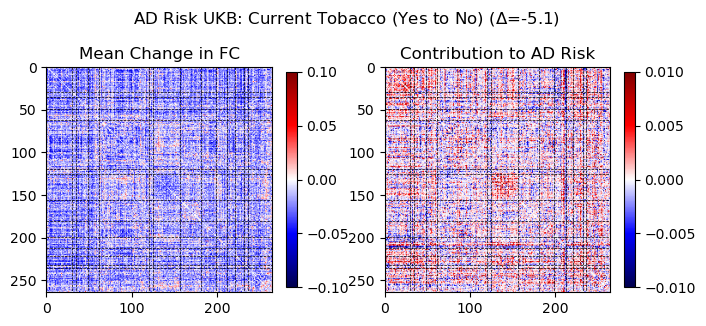

In [77]:
# Make two graphs: one mean change in FC, the other mean change in AD risk
# Use seismic or RdBu colormaps

divis = [0,30,35,49,62,120,125,156,181,199,212,221,232,236,264]
labels = ['SMTH','SMTM','CNG','AUD','DMN','MEM','VIS','FRNT','SAL','SUB','VTRL','DRSL','CBL','UNK']

def getlabel(i):
    for j in range(len(divis)):
        if i >= divis[j] and i < divis[j+1]:
            return labels[j]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1,2,figsize=(8,3.5))

subject = 'UKB: Current Tobacco (Yes to No)'
delta = '-5.1'
diff = nsynth_mean-synth_mean
diffw = w*diff
tit = subject.replace(' ', '_')
scale = 0.1

norm1 = TwoSlopeNorm(vmax=scale, vmin=-scale, vcenter=0)
norm2 = TwoSlopeNorm(vmax=scale/10, vmin=-scale/10, vcenter=0)

pos = ax[0].imshow(vec2mat(diff), norm=norm1, cmap='seismic')
fig.colorbar(pos, ax=ax[0], shrink=0.8)

pos = ax[1].imshow(vec2mat(diffw), norm=norm2, cmap='seismic')
fig.colorbar(pos, ax=ax[1], shrink=0.8)

for i in range(len(divis)-1):
    d = divis[i+1]
    ax[0].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[0].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([0, 264], [d, d], color='black', linewidth=0.5, linestyle='--')
    ax[1].plot([d, d], [0, 264], color='black', linewidth=0.5, linestyle='--')

ax[0].set_xlim([0,264])
ax[0].set_ylim([264,0])
ax[1].set_xlim([0,264])
ax[1].set_ylim([264,0])

ax[0].set_title('Mean Change in FC')
ax[1].set_title('Contribution to AD Risk')

fig.suptitle(f'AD Risk {subject} ($\\Delta$={delta})')
fig.show()
# fig.savefig(f'/home/anton/Documents/Yale/UKB/Figures/FCChanges2/{tit}.pdf')

In [78]:
# Individual ROIs

a,b = np.triu_indices(264,1)
top = np.argsort(np.abs(diffw))[::-1]
num = 8

print(tit, delta)
print('Individual ROIs')
for i in range(num):
    r1 = a[top[i]]
    r2 = b[top[i]]
    print(top[i], r1, r2, getlabel(r1), getlabel(r2), diffw[top[i]])

vals = []
sums = []
labs = []
W = vec2mat(diffw)
net_sums = [0]*14
net_means = [0]*14

for i in range(len(divis)-1):
    for j in range(i,len(divis)-1):
        r1a = divis[i]
        r1b = divis[i+1]
        r2a = divis[j]
        r2b = divis[j+1]
        WW = W[r1a:r1b,r2a:r2b]
        net_sums[i] += np.sum(WW)
        net_means[i] += np.mean(WW)
        if j >= i:
            val = np.mean(WW)
            vals.append(val)
            val = np.sum(WW)
            sums.append(val)
            labs.append(f'{labels[i]}-{labels[j]}')

idcs = np.argsort(np.abs(vals))[::-1]

print('Networks Mean')
for i in range(num):
    print(vals[idcs[i]], labs[idcs[i]])

idcs = np.argsort(np.abs(sums))[::-1]

print('Networks Sum')
for i in range(num):
    print(sums[idcs[i]], labs[idcs[i]])

print('Agg Sum')
for s in net_sums:
    print(s)

print('Agg Avg')
for a in net_means:
    print(a)

UKB:_Current_Tobacco_(Yes_to_No) -5.1
Individual ROIs
12960 54 244 AUD UNK 0.023371001974818294
32704 200 205 SUB SUB -0.022856583211647675
9477 38 225 CNG DRSL 0.02187856932461578
2060 7 248 SMTH UNK -0.021643707765764013
16603 73 106 DMN DMN -0.01957875056703261
4171 16 100 SMTH DMN -0.01949318282585204
16660 73 163 DMN FRNT -0.019422288574297675
4178 16 107 SMTH DMN 0.01917354731919474
Networks Mean
0.0024264947196627885 DRSL-DRSL
0.0018014677767061729 VIS-VIS
0.0015628547526389783 SMTH-SMTM
0.001539268623988261 CNG-DRSL
0.0014530837040931106 SMTM-DRSL
0.0013999346526691176 SMTH-SMTH
-0.00139114233304671 SMTM-CBL
0.0013827772387537884 SMTH-DRSL
Networks Sum
1.7312105334146322 VIS-VIS
1.2599411874022057 SMTH-SMTH
-0.5149282106302749 DMN-FRNT
0.507430031905638 SMTH-AUD
-0.47209376463121233 DMN-VIS
0.4563164887887502 SMTH-DRSL
-0.4487209307661344 SMTH-SUB
0.41100353401555867 VIS-DRSL
Agg Sum
2.4067204847078387
0.27368513518926996
0.09905200684612189
0.818590384166717
-1.505136790362395

In [6]:
# Make tsne graph

import numpy as np

xx = vae.transform(len(dct['demos'][0]), dct['demos'], dct['types'])

print(len(xx))

700


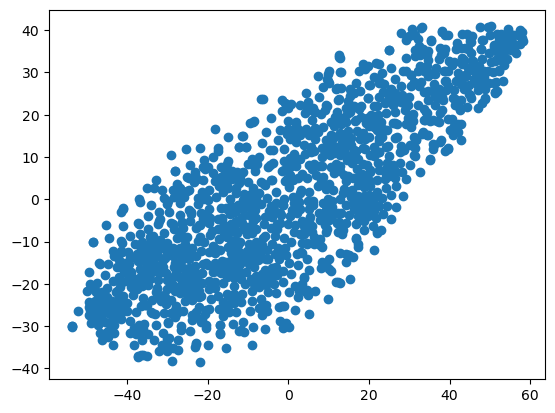

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

allx = np.concatenate([fcs, xx])

z = TSNE(n_components=2, perplexity=10).fit_transform(allx)
plt.scatter(z[:,0], z[:,1])

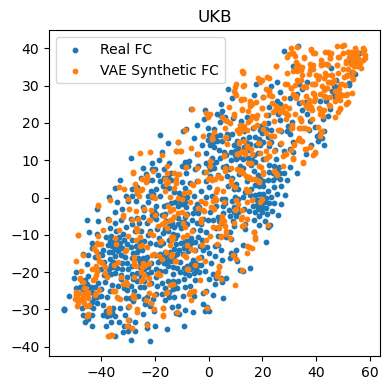

In [10]:
N = len(fcs)

fig, ax = plt.subplots(1,1,figsize=(4,4))

ax.scatter(z[:N,0],z[:N,1],s=10,label='Real FC')
ax.scatter(z[N:,0],z[N:,1],s=10,label='VAE Synthetic FC')

ax.legend()
ax.set_title('UKB')

fig.tight_layout()
fig.savefig('/home/anton/Documents/Yale/UKB/Figures/UKB-tsne.pdf')
fig.show()